Training with class weights and tuning for accuracy

In [1]:
import os
os.chdir('../')

In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load and preprocess the audio files
def load_audio_files(audio_directory):
    audio_files = []
    folders = os.listdir(audio_directory)
    folders.reverse()
    for label, folder in enumerate(folders):
        folder_path = os.path.join(audio_directory, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.wav') or filename.endswith('.mp3'):
                filepath = os.path.join(folder_path, filename)
                audio_files.append((filepath, label))
    return audio_files

def split_audio_into_segments(audio, sr, segment_length=30):
    segment_length = segment_length * sr
    num_segments = len(audio) // segment_length
    segments = [audio[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
    return segments

def create_spectrogram(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

def random_crop(spectrogram, crop_size):
    pad_width_x = max(crop_size - spectrogram.shape[1], 0)
    pad_width_y = max(crop_size - spectrogram.shape[0], 0)
    spectrogram = np.pad(spectrogram, ((0, pad_width_y), (0, pad_width_x)), mode='constant')
    max_x = spectrogram.shape[1] - crop_size
    max_y = spectrogram.shape[0] - crop_size
    x = np.random.randint(0, max_x + 1)
    y = np.random.randint(0, max_y + 1)
    cropped_spectrogram = spectrogram[y:y + crop_size, x:x + crop_size]
    return cropped_spectrogram

def time_shift(spectrogram, max_shift):
    shift_amount = np.random.randint(-max_shift, max_shift)
    shifted_spectrogram = np.roll(spectrogram, shift_amount, axis=1)
    return shifted_spectrogram

def add_noise(spectrogram, noise_factor=0.005):
    noise = np.random.randn(*spectrogram.shape) * noise_factor
    noisy_spectrogram = spectrogram + noise
    return noisy_spectrogram

def augment_data(spectrogram):
    spectrogram = random_crop(spectrogram, crop_size=224)
    spectrogram = time_shift(spectrogram, max_shift=10)
    spectrogram = add_noise(spectrogram, noise_factor=0.005)
    return spectrogram

def load_test_file(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio, sr

def extract_segment(audio, sr, segment_length=10):
    segment_length = segment_length * sr
    if len(audio) < segment_length:
        pad_width = segment_length - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')
    start = np.random.randint(0, len(audio) - segment_length + 1)
    segment = audio[start:start + segment_length]
    return segment

def create_test_set_from_audio(file_path):
    audio, sr = load_test_file(file_path)
    segment = extract_segment(audio, sr, segment_length=10)
    spectrogram = create_spectrogram(segment, sr)
    augmented_spectrogram = augment_data(spectrogram)
    augmented_spectrogram = np.expand_dims(augmented_spectrogram, axis=-1)
    augmented_spectrogram = np.repeat(augmented_spectrogram, 3, axis=-1)
    return augmented_spectrogram

In [3]:
# Load audio files
audio_directory = "artifacts/data_ingestion/KAGGLE/AUDIO"
audio_files = load_audio_files(audio_directory)

spectrograms = []
labels = []

for file, label in audio_files:
    audio, sr = librosa.load(file, sr=16000)
    segments = split_audio_into_segments(audio, sr, segment_length=10)
    for segment in segments:
        spectrogram = create_spectrogram(segment, sr)
        augmented_spectrogram = augment_data(spectrogram)
        spectrograms.append(augmented_spectrogram)
        labels.append(label)

spectrograms = np.array(spectrograms)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(spectrograms, labels, test_size=0.2, random_state=42, stratify=labels)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)

In [4]:
np.bincount(y_train)

array([ 298, 2089], dtype=int64)

In [5]:
np.bincount(y_val)

array([ 75, 522], dtype=int64)

In [6]:
neg = 298
pos = 2089
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 4.01
Weight for class 1: 0.57


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, class_weight=class_weight, callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 39s 487ms/step - loss: 0.9478 - accuracy: 0.8140 - val_loss: 0.3928 - val_accuracy: 0.9229
Epoch 2/100
75/75 [==============================] - 35s 464ms/step - loss: 0.4134 - accuracy: 0.9003 - val_loss: 0.3282 - val_accuracy: 0.9296
Epoch 3/100
75/75 [==============================] - 35s 471ms/step - loss: 0.2983 - accuracy: 0.9380 - val_loss: 0.2635 - val_accuracy: 0.9581
Epoch 4/100
75/75 [==============================] - 35s 473ms/step - loss: 0.2991 - accuracy: 0.9233 - val_loss: 0.4284 - val_accuracy: 0.8744
Epoch 5/100
75/75 [==============================] - 35s 470ms/step - loss: 0.2541 - accuracy: 0.9510 - val_loss: 0.2914 - val_accuracy: 0.9330
Epoch 6/100
75/75 [==============================] - 35s 464ms/step - loss: 0.2285 - accuracy: 0.9564 - val_loss: 0.2162 - val_accuracy: 0.9598
Epoch 7/100
75/75 [==============================] - 35s 461ms/step - loss: 0.2078 - accuracy: 0.9615 - val_loss: 0.3239 - val_accuracy:

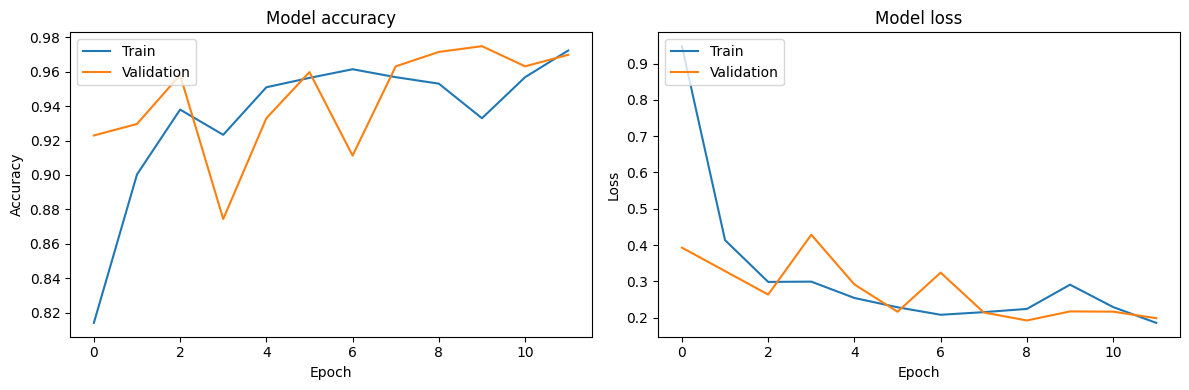

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [9]:
# Testing on a new file
test_file_path = 'artifacts/data_ingestion/DEMONSTRATION/DEMONSTRATION/matthew_mcconaughey_winning_best_actor__86th_oscars_2014-cut.mp3' #2,4,1,2
test_set = create_test_set_from_audio(test_file_path)
test_set = np.expand_dims(test_set, axis=0)

# Make predictions
prediction = model2.predict(test_set)

# Output the prediction
print(prediction)

1/1 [==============================] - 0s 25ms/step
[[0.12580384]]


In [10]:
from sklearn.metrics import classification_report

y_pred = model2.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_val, y_pred, target_names=['Real', 'Fake']))

19/19 [==============================] - 6s 297ms/step
              precision    recall  f1-score   support

        Real       0.90      0.87      0.88        75
        Fake       0.98      0.99      0.98       522

    accuracy                           0.97       597
   macro avg       0.94      0.93      0.93       597
weighted avg       0.97      0.97      0.97       597



In [14]:
import pandas as pd
from scipy import stats

In [15]:
test_file_path = 'artifacts/data_ingestion/DEMONSTRATION/DEMONSTRATION/'
files = os.listdir(test_file_path)
actuals = [1,0,1,0]
a = list(zip(actuals, files))
results = []

def predict_with_models(test_set, model):
    prediction = (model.predict(test_set) > 0.5).astype(int)
    return prediction[0][0]

for filenum, file in enumerate(a):
    for i in range(10): 
        # Make predictions
        test_set1 = create_test_set_from_audio(os.path.join(test_file_path, file[1]))
        test_set1 = np.expand_dims(test_set1, axis=0)
        prediction1 = predict_with_models(test_set1, model2)
        
        test_set2 = create_test_set_from_audio(os.path.join(test_file_path, file[1]))
        test_set2 = np.expand_dims(test_set2, axis=0)
        prediction2 = predict_with_models(test_set2, model2)
        
        test_set3 = create_test_set_from_audio(os.path.join(test_file_path, file[1]))
        test_set3 = np.expand_dims(test_set3, axis=0)
        prediction3 = predict_with_models(test_set3, model2)
        
        test_set4 = create_test_set_from_audio(os.path.join(test_file_path, file[1]))
        test_set4 = np.expand_dims(test_set4, axis=0)
        prediction4 = predict_with_models(test_set4, model2)
        
        test_set5 = create_test_set_from_audio(os.path.join(test_file_path, file[1]))
        test_set5 = np.expand_dims(test_set5, axis=0)
        prediction5 = predict_with_models(test_set5, model2)
        
        final_pred = stats.mode([prediction1, prediction2, prediction3, prediction4, prediction5])
        
        results.append({
                'File': filenum,
                'Loop': i,
                'Actual': file[0],
                'Final Prediction': final_pred[0][0]
            })    

df_results = pd.DataFrame(results)
display(df_results)
#df_results.to_csv('compare.csv')

1/1 [==============================] - 0s 26ms/step


C:\Users\Vishnu\AppData\Local\Temp\ipykernel_16724\1251355348.py:34: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred = stats.mode([prediction1, prediction2, prediction3, prediction4, prediction5])


1/1 [==============================] - 0s 26ms/step


,File,Loop,Actual,Final Prediction
0,0,0,1,1
1,0,1,1,1
2,0,2,1,1
3,0,3,1,1
4,0,4,1,1
5,0,5,1,1
6,0,6,1,1
7,0,7,1,1
8,0,8,1,1
9,0,9,1,1


In [20]:
# Example usage
test_file_path = 'artifacts/data_ingestion/DEMONSTRATION/DEMONSTRATION/matthew_mcconaughey_winning_best_actor__86th_oscars_2014-cut.mp3'
results = []
probs = []
for i in range(5):
    test_set = create_test_set_from_audio(test_file_path)
    test_set = np.expand_dims(test_set, axis=0)
    # Make predictions
    prob = model2.predict(test_set)[0][0]
    prediction = (prob > 0.5).astype(int)
    probs.append(prob)
    results.append(prediction)

print(results)
print(probs)
final_pred = stats.mode(results)[0][0]

# Output the prediction
print(final_pred)

1/1 [==============================] - 0s 25ms/step
[0, 0, 0, 0, 0]
[0.27448735, 0.38347638, 0.15582149, 0.15078399, 0.031103577]
0


C:\Users\Vishnu\AppData\Local\Temp\ipykernel_16724\3001205811.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred = stats.mode(results)[0][0]
